In [17]:
#import the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [18]:
# Importing the dataset
csdv_df = pd.read_csv('customer_segmentation.csv')


In [20]:


csdv_df.head() #first 5 entries of the dataset to understand the data we are dealing with


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_type,payment_installments,...,seller_id,shipping_limit_date,price,freight_value,seller_city,seller_state,product_category_name,product_name_lenght,product_description_lenght,product_category_name_english
0,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,boleto,1,...,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.7,22.76,belo horizonte,SP,perfumaria,29,178,perfumery
1,86674ccaee19790309333210917b2c7d,1b338293f35549b5e480b9a3d7bbf3cd,delivered,2018-08-09 11:37:35,2018-08-09 14:35:19,2018-08-10 14:34:00,2018-08-14 18:51:47,2018-08-22 00:00:00,credit_card,5,...,289cdb325fb7e7f891c38608bf9e0962,2018-08-13 14:31:29,116.9,18.92,belo horizonte,SP,perfumaria,29,178,perfumery
2,aee682982e18eb4714ce9f97b15af5e2,8858442ea4d5dc5bb9e118e8f728095d,delivered,2018-07-09 18:46:28,2018-07-11 03:45:45,2018-07-11 15:01:00,2018-07-12 18:14:35,2018-07-18 00:00:00,boleto,1,...,289cdb325fb7e7f891c38608bf9e0962,2018-07-13 03:45:45,118.7,9.34,belo horizonte,SP,perfumaria,29,178,perfumery
3,d543201a9b42a1402ff97e65b439a48b,971bf8f42a9f8cb3ead257854905b454,delivered,2018-08-21 10:00:25,2018-08-21 10:50:54,2018-08-22 15:21:00,2018-08-28 18:58:22,2018-09-10 00:00:00,credit_card,2,...,289cdb325fb7e7f891c38608bf9e0962,2018-08-23 10:50:54,116.9,22.75,belo horizonte,SP,perfumaria,29,178,perfumery
4,d543201a9b42a1402ff97e65b439a48b,971bf8f42a9f8cb3ead257854905b454,delivered,2018-08-21 10:00:25,2018-08-21 10:50:54,2018-08-22 15:21:00,2018-08-28 18:58:22,2018-09-10 00:00:00,credit_card,2,...,289cdb325fb7e7f891c38608bf9e0962,2018-08-23 10:50:54,116.9,22.75,belo horizonte,SP,perfumaria,29,178,perfumery


In [21]:
print("Dataset info:")
display(csdv_df.info())
print()

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13801 entries, 0 to 13800
Data columns (total 26 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   order_id                       13801 non-null  object 
 1   customer_id                    13801 non-null  object 
 2   order_status                   13801 non-null  object 
 3   order_purchase_timestamp       13801 non-null  object 
 4   order_approved_at              13801 non-null  object 
 5   order_delivered_carrier_date   13801 non-null  object 
 6   order_delivered_customer_date  13801 non-null  object 
 7   order_estimated_delivery_date  13801 non-null  object 
 8   payment_type                   13801 non-null  object 
 9   payment_installments           13801 non-null  int64  
 10  payment_value                  13801 non-null  float64
 11  customer_unique_id             13801 non-null  object 
 12  customer_city                  1

None

In [22]:
print("Dataset shape:")
display(csdv_df.shape) #number of rows and columns of our dataset
print()

Dataset shape:


(13801, 26)

In [23]:
display(csdv_df.describe()) #compute some useful descriptive statistics which summarize the central tendency, dispersion, and shape of a dataset’s distribution, excluding NaN values

,payment_installments,payment_value,order_item_id,price,freight_value,product_name_lenght,product_description_lenght
count,13801.000000,13801.000000,13801.000000,13801.000000,13801.000000,13801.000000,13801.000000
mean,3.014637,194.349691,1.230491,130.947103,21.938168,49.300703,814.330411
std,2.801721,294.854258,0.737495,210.712421,18.567013,9.759529,648.790194
min,1.000000,0.050000,1.000000,0.850000,0.000000,8.000000,4.000000
25%,1.000000,66.750000,1.000000,40.000000,12.870000,43.000000,366.000000
50%,2.000000,120.290000,1.000000,79.000000,18.230000,52.000000,631.000000
75%,4.000000,206.780000,1.000000,139.000000,23.310000,57.000000,1030.000000
max,20.000000,7274.880000,13.000000,4590.000000,375.280000,69.000000,3985.000000


Io toglierei product_category_name, product_name_length e product_description_length (non so se altro)

In [27]:
csdv_df.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'payment_type', 'payment_installments', 'payment_value',
       'customer_unique_id', 'customer_city', 'customer_state',
       'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date',
       'price', 'freight_value', 'seller_city', 'seller_state',
       'product_category_name', 'product_name_lenght',
       'product_description_lenght', 'product_category_name_english'],
      dtype='object')

In [32]:
csdv_df_new = csdv_df[['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'payment_type', 'payment_installments', 'payment_value',
       'customer_unique_id', 'customer_city', 'customer_state',
       'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date',
       'price', 'freight_value', 'seller_city', 'seller_state', 'product_category_name_english']]

csdv_df_new.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'payment_type', 'payment_installments', 'payment_value',
       'customer_unique_id', 'customer_city', 'customer_state',
       'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date',
       'price', 'freight_value', 'seller_city', 'seller_state',
       'product_category_name_english'],
      dtype='object')

In [24]:
# null values
csdv_df_new.isna().sum()

order_id                         0
customer_id                      0
order_status                     0
order_purchase_timestamp         0
order_approved_at                0
order_delivered_carrier_date     0
order_delivered_customer_date    0
order_estimated_delivery_date    0
payment_type                     0
payment_installments             0
payment_value                    0
customer_unique_id               0
customer_city                    0
customer_state                   0
order_item_id                    0
product_id                       0
seller_id                        0
shipping_limit_date              0
price                            0
freight_value                    0
seller_city                      0
seller_state                     0
product_category_name            0
product_name_lenght              0
product_description_lenght       0
product_category_name_english    0
dtype: int64

There are no null values

In [31]:
csdv_df_new.isnull().sum()

order_id                         0
customer_id                      0
order_status                     0
order_purchase_timestamp         0
order_approved_at                0
order_delivered_carrier_date     0
order_delivered_customer_date    0
order_estimated_delivery_date    0
payment_type                     0
payment_installments             0
payment_value                    0
customer_unique_id               0
customer_city                    0
customer_state                   0
order_item_id                    0
product_id                       0
seller_id                        0
shipping_limit_date              0
price                            0
freight_value                    0
seller_city                      0
seller_state                     0
product_category_name            0
product_name_lenght              0
product_description_lenght       0
product_category_name_english    0
dtype: int64

Greve non ci stanno i null

In [33]:
csdv_df_new[['shipping_limit_date']]

,shipping_limit_date
0,2018-07-30 03:24:27
1,2018-08-13 14:31:29
2,2018-07-13 03:45:45
3,2018-08-23 10:50:54
4,2018-08-23 10:50:54
...,...
13796,2018-07-20 13:30:36
13797,2018-05-11 20:51:50
13798,2018-05-04 14:53:18
13799,2018-07-16 22:45:43


This attribute is not described, but we deduced that it corresponds to the date and time deadline at which the ship can be sent.

In [34]:
csdv_df_new[['order_delivered_carrier_date']]

,order_delivered_carrier_date
0,2018-07-26 14:31:00
1,2018-08-10 14:34:00
2,2018-07-11 15:01:00
3,2018-08-22 15:21:00
4,2018-08-22 15:21:00
...,...
13796,2018-07-27 07:26:00
13797,2018-05-08 15:04:00
13798,2018-05-02 15:25:00
13799,2018-07-11 22:45:43


<AxesSubplot: >

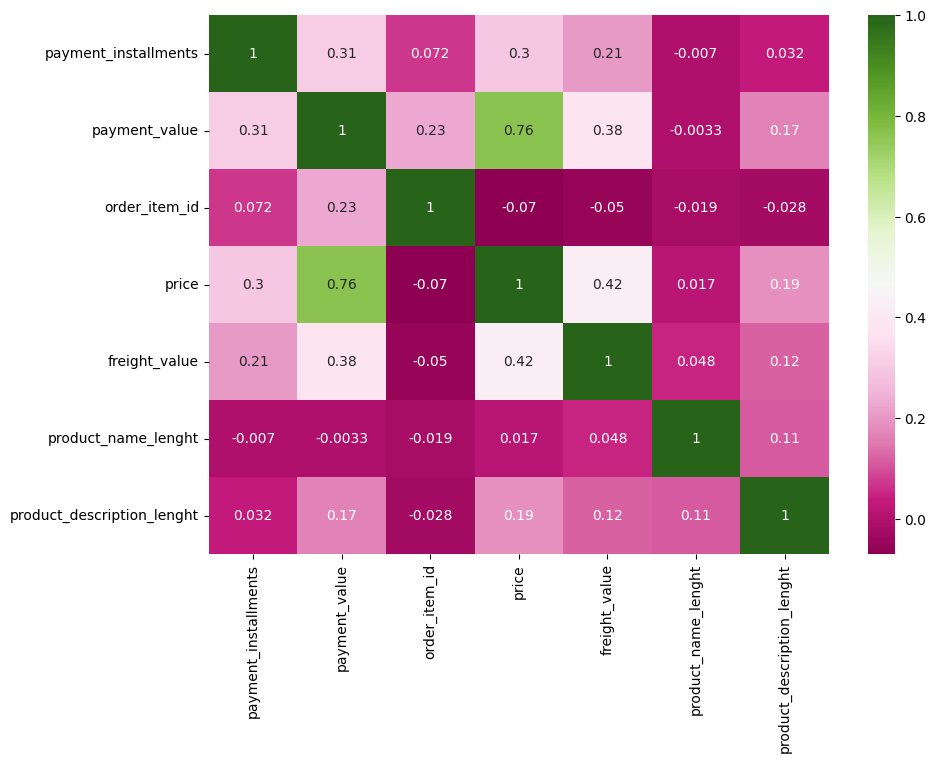

In [28]:
correlation = csdv_df_new.corr(numeric_only=True) #compute pairwise correlation of columns excluding NA/null values
table = plt.figure(figsize=(10,7))
sns.heatmap(correlation, annot=True, cmap="PiYG")

This evaluates the correlation only among numerical variables

In [26]:
#non so se serve
#snadv_df = pd.get_dummies(csdv_df)
#snadv_df.head()

In [41]:
customer_state_counts = csdv_df_new.groupby('customer_state').size()
customer_state_counts

customer_state
AC       5
AL      56
AM      24
AP      12
BA     536
CE     207
DF     298
ES     284
GO     272
MA      86
MG    1466
MS     111
MT     154
PA     150
PB      94
PE     270
PI      80
PR     631
RJ    1766
RN      85
RO      26
RR       9
RS     631
SC     432
SE      55
SP    6016
TO      45
dtype: int64

These are the abbreviations of the federative states of Brazil

In [42]:
customer_state_counts_df = pd.DataFrame([customer_state_counts]).T.reset_index()
customer_state_counts_df.columns = ['customer_state', 'Count']
customer_state_counts_df

,customer_state,Count
0,AC,5
1,AL,56
2,AM,24
3,AP,12
4,BA,536
5,CE,207
6,DF,298
7,ES,284
8,GO,272
9,MA,86


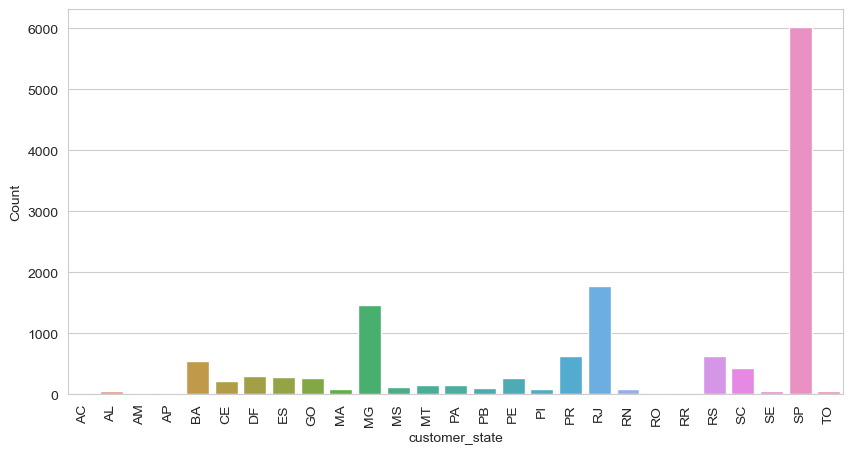

In [59]:
plt.figure(figsize=(10,5))
sns.barplot(x='customer_state', y='Count', data=customer_state_counts_df)
plt.xticks(rotation=90)
plt.show()

We can notice that the majority of the customers purchase from São Paulo state.

KeyboardInterrupt: 

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f78f14148b0> (for post_execute):


KeyboardInterrupt: 

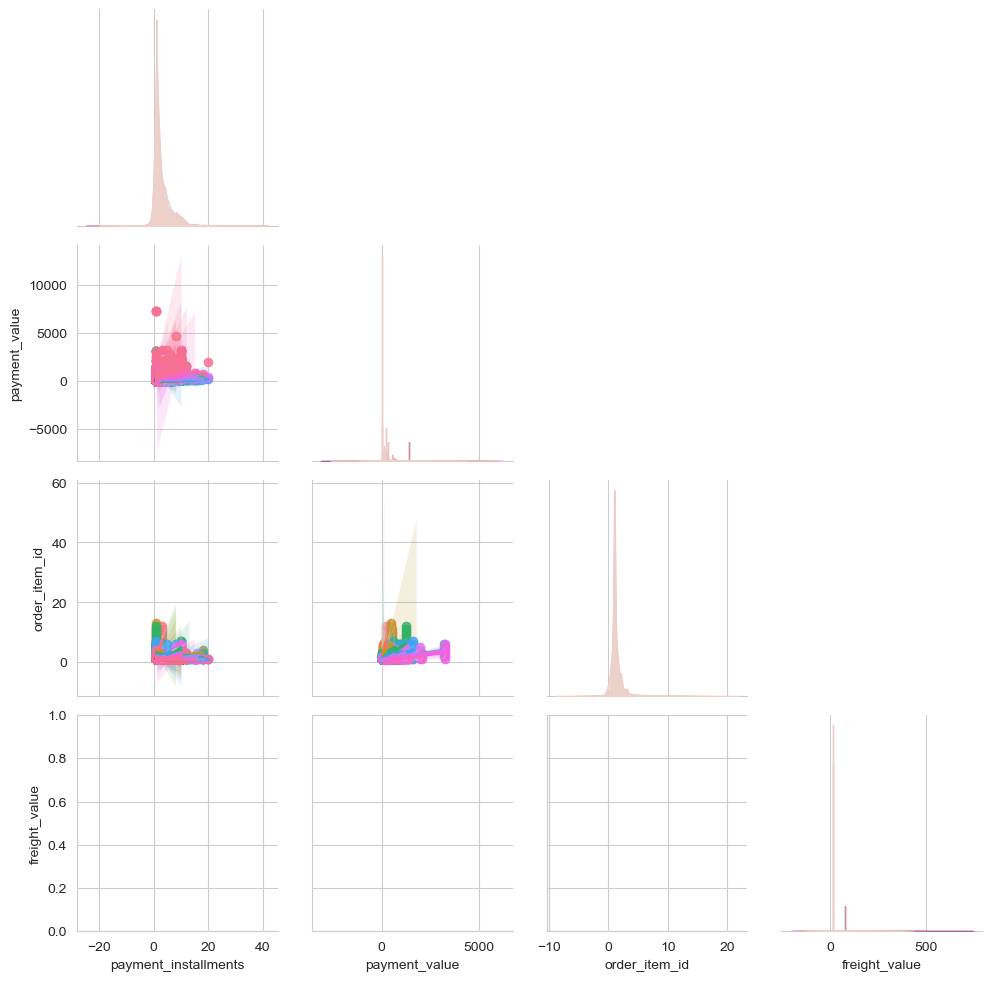

In [61]:
sns.pairplot(csdv_df_new, hue='price', corner=True, kind='reg')

### FARE SCATTERPLOT DI ESTIMATED DELIVERY E ACTUAL DELIVERY